In [33]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt

from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff
from nibabel.affines import from_matvec, to_matvec, apply_affine

## Variables

In [34]:
dataset = 'KORA' # 'NAKO', 'UKB', 'KORANAKOUKB'
file_type = 'nifti'  # 'nerd'
target_file_type = 'nifti'
default_ornt = 'RAS'
target_res = [2,2,3]
default_view = ['Saggital', 'Coronal', 'Axial']
default_ref_view = 'Sagittal'
optimization = 'N4'  # Intensity, Min-Max, Fat-Water-Swap
is_cropping = True
default_world_coords = [500, 500, 1000]

default_output_path = './temp'


## Utilities

In [35]:
def create_if_not(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Creating the default paths needed for smooth execution.
create_if_not(default_output_path)

def volume_viewer(vol, axis_idx=0):
    if axis_idx > 2:
        raise Exception('Axis Index cannot be more than 2! Ideally 0: Sagittal, 1: Coronal, 2: Axial.')
    axis = vol.shape
    plt.imshow(vol[axis[axis_idx]//2])
    plt.show()
    
def volume_3_view_viewer(vol):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True)
    axis = vol.shape
    
    ax1.imshow(vol[axis[0]//2])
    ax2.imshow(vol[:, axis[1]//2, :])
    ax3.imshow(vol[:, :, axis[2]//2])
    
    plt.show()
    
def get_volume_data(img):
    return img.get_fdata()

def save_volume(img, file_name):
    nb.save(img, f'{default_output_path}/{file_name}.nii.gz')

## Volume Loader / Reader

In [36]:
def nrrd_reader(file_path):
    _nrrd = nrrd.read(file_path)
    data = _nrrd[0]
    header = _nrrd[1]
    return data, header, None

def nibabel_reader(file_path):
    volume_nifty = nb.load(file_path)
    volume = get_volume_data(volume_nifty)
    return volume, volume_nifty.header, volume_nifty

def file_reader(file_path, file_type=None):
    header_mat = np.empty_like((4,4))
    if file_type == None:
        file_type = file_path.split('.')[-1]
    if file_type == 'nrrd':
        data, header, img = nrrd_reader(file_path)
        affine = header['space directions']
        affine = affine[:3, :3]
        origins = header['space origin']
        origins = origins[:3]
        t_mat = from_matvec(affine, origins)
        img = nb.Nifti1Image(data, t_mat) if img is None else img
        header_mat = t_mat
        
    else:
        data, header, img = nibabel_reader(file_path)
        header_mat = header
    
    return data, header_mat, img

## Transformation :- Reading Direction Optimization

In [37]:
def do_nibabel_transform_to_ras(img):
    ###### use nibabel transform
    
    affine = img.affine
    orig_ornt = nb.io_orientation(affine)
#     print('orig image orientation: ', orig_ornt)
    #print('transform to RAS')
    targ_ornt = axcodes2ornt('RAS')
#     print('target orientation: ', targ_ornt)
    transform = ornt_transform(orig_ornt, targ_ornt)
    #fat_tmp = fat.get_data()
    img = img.as_reoriented(transform)
    #print('img shape after nibabel transform: ', img.get_data().shape)

    #########################
    return img

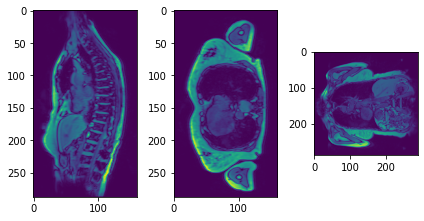

[[ -1.70138884   0.           0.         266.92883301]
 [  0.           0.          -1.69999695  97.33310699]
 [  0.          -1.70138884   0.          24.67601776]
 [  0.           0.           0.           1.        ]]


In [38]:
file_to_read = './datasets/kora/KORA2460249/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nii.gz'

data, header, img = file_reader(file_to_read, 'nifti')
# volume_viewer(data)
volume_3_view_viewer(get_volume_data(img))

# print(img.affine)
    

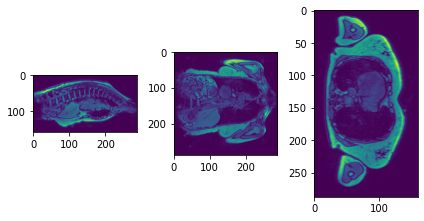

[[   1.70138884    0.            0.         -221.3697629 ]
 [   0.            1.69999695    0.         -172.96640778]
 [   0.            0.            1.70138884 -463.62257814]
 [   0.            0.            0.            1.        ]]


In [39]:
img = do_nibabel_transform_to_ras(img)
volume_3_view_viewer(get_volume_data(img))
save_volume(img, 'kora_processed')
# print(img.affine)

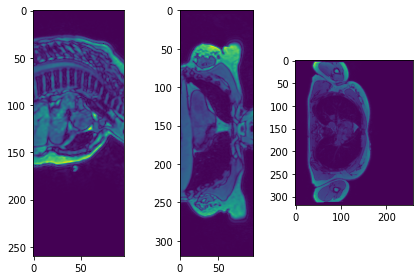

[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -472.5    ]
 [   0.         0.         0.         1.     ]]


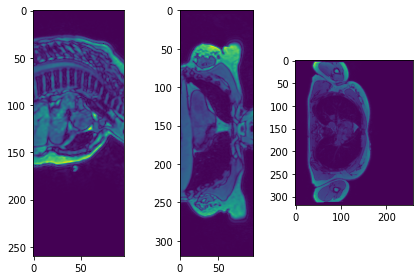

[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -472.5    ]
 [   0.         0.         0.         1.     ]]


In [40]:
file_to_read = './datasets/nako/100017/100017_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_1.nii.gz'

data, header, img = file_reader(file_to_read)
volume_3_view_viewer(get_volume_data(img))
# print(img.affine)
img = do_nibabel_transform_to_ras(img)
volume_3_view_viewer(get_volume_data(img))
# print(img.affine)
save_volume(img, 'nako_processed')
# print(data.shape, header)
#     

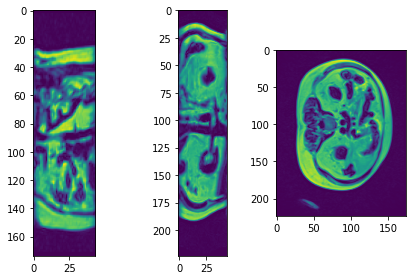

[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]]


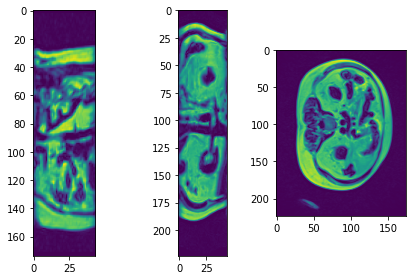

[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]]


In [41]:
file_to_read = './datasets/ukb/5331775_20201_2_0/Dixon_BH_17s_F_Dixon_BH_17s.nii.gz'

data, header, img = file_reader(file_to_read)
volume_3_view_viewer(get_volume_data(img))
# print(img.affine)
img = do_nibabel_transform_to_ras(img)
volume_3_view_viewer(get_volume_data(img))
# print(img.affine)
save_volume(img, 'ukb_processed')
    